アイリスデータセット

In [25]:
pip install japanize_matplotlib

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install torchviz

In [27]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [30]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

In [31]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [32]:
# データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


In [33]:
# データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


In [34]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


In [35]:
# データを正解値ごとに分割

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

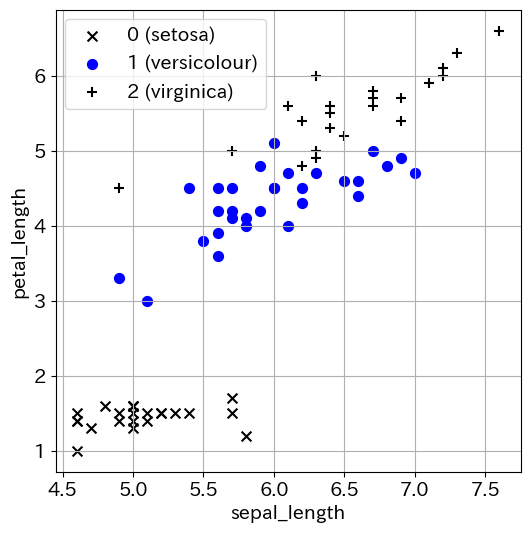

In [36]:
# 散布図の表示

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

モデル定義

In [37]:
# 学習用パラメータ設定

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
# 分類先クラス数　今回は3になる
n_output = len(list(set(y_train)))

# 結果確認
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [38]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)

        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1

# インスタンスの生成
net = Net(n_input, n_output)

In [39]:
# モデル内のパラメータの確認
# l1.weightが行列にl1.biasがベクトルになっている

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [40]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [41]:
# モデルのサマリー表示

summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [42]:
# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

In [43]:
# 入力変数x_trainと正解値 y_trainのテンソル変数化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のテンソル変数化

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [44]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [45]:
# この時点でのoutputsではmax関数の挙動がわかりにくいので
# 一時的に下記の形に差し替える

w = np.array([
    [0.0059, 0.9056, 0.0885],
    [0.0069, 0.9792, 0.0139],
    [0.9452, 0.0548, 0.],
    [0., 0.0404, 0.9596],
    [0.0001, 0.1743, 0.8256],
])
outputs = torch.tensor(w).float()

# torch.max関数呼び出し
# 2つめの引数は軸を意味している。1だと行ごとの集計

print(torch.max(outputs, 1))

torch.return_types.max(
values=tensor([0.9056, 0.9792, 0.9452, 0.9596, 0.8256]),
indices=tensor([1, 1, 0, 2, 2]))


In [46]:
# ラベル値の配列を取得
torch.max(outputs, 1)[1]

tensor([1, 1, 0, 2, 2])

In [47]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

メインループ

In [48]:
for epoch in range(num_epochs):

    # 訓練フェーズ

    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 予測ラベル算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ((epoch) % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [10/10000], loss: 1.03580 acc: 0.40000 val_loss: 1.06403, val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347, val_acc: 0.26667
Epoch [30/10000], loss: 0.97672 acc: 0.40000 val_loss: 1.00264, val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351, val_acc: 0.26667
Epoch [50/10000], loss: 0.92616 acc: 0.48000 val_loss: 0.94631, val_acc: 0.38667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098, val_acc: 0.56000
Epoch [70/10000], loss: 0.88212 acc: 0.70667 val_loss: 0.89740, val_acc: 0.60000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545, val_acc: 0.61333
Epoch [90/10000], loss: 0.84373 acc: 0.70667 val_loss: 0.85500, val_acc: 0.62667
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594, val_acc: 0.62667
Epoch [110/10000], loss: 0.81019 acc: 0.72000 val_loss: 0.81815, val_acc: 0.62667
Epoch [120/10000], loss: 0.

In [49]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.09263 精度: 0.26667
最終状態: 損失: 0.19795 精度: 0.96000


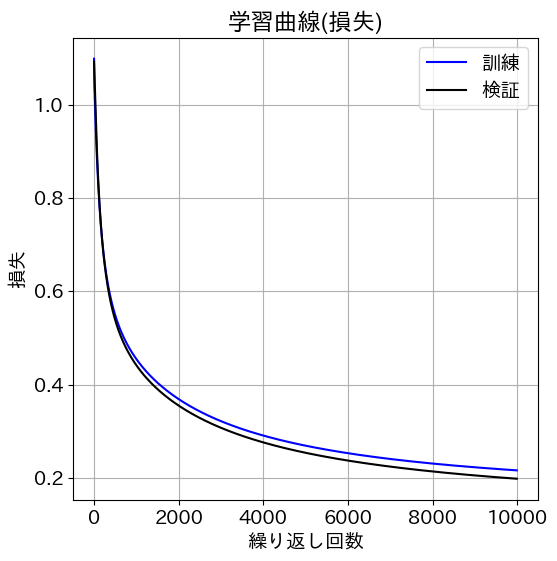

In [50]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

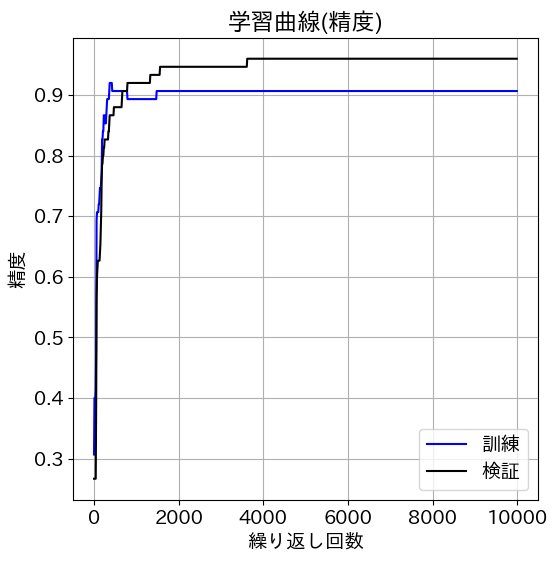

In [51]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()